#### Module import & Load Data

In [2]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [4]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import nltk
# import seaborn as sns
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [5]:
train1 = pd.read_csv('c:/data/project/train.csv')
test = pd.read_csv('c:/data/project/test.csv')

In [22]:
train_nlp = train1.copy()
train_nlp.info()
train_nlp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


#### 전처리 및 DownSampling

In [23]:
from sklearn.utils import resample

subset_0 = train_nlp[train_nlp["first_party_winner"] == 0]
subset_1 = train_nlp[train_nlp["first_party_winner"] == 1]

subset_1_downsampled = resample(subset_1,
                                replace=False,
                                n_samples=800,
                                random_state=42)

train_nlp = pd.concat([subset_0, subset_1_downsampled])

In [24]:
train_nlp.head()

,ID,first_party,second_party,facts,first_party_winner
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
14,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",Named plaintiff James Thole and others brought...,0
16,TRAIN_0016,Plyler,Doe,A revision to the Texas education laws in 1975...,0
21,TRAIN_0021,Bassam Yacoub Salman,United States,Maher Kara joined Citigroup’s healthcare inves...,0


#### 토큰화 확인

In [18]:
# corpus = train_nlp["facts"]
# lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
# 어절 별로 키워드 반환
# lst_tokens

# text='Ramon Nelson was (riding his) bike when he'
# lst=text.split()
# lst

### 불용어 사전 정의 (사용자 지정 & 기본 제공[english])

In [17]:
# https://gist.github.com/nealrs/96342d8231b75cf4bb82
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}


In [19]:
##### 불용어 처리 및 어간과 표제어 추출 함수 #####

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # 정규식, 치환 문자열, src 문자열 입력 -> 해당 문자가 발견되지 않는 경우 space bar로 변환, 단어별 split을 위한 작업

    text = re.sub(r'\([^)]*\)',' ',text)  # 문자열 괄호 제거
    text = re.sub('"', ' ', text)  # 따옴표 제거
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])  # 약어 정규화
    text = re.sub(r"'s\b"," ",text)  # 소유격 제거

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [20]:
##### 단어와 빈도수 측정 및 시각화 함수 #####

def word_freq(data, columns, titleName=None, graph=False):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

    dic_word_freq = nltk.FreqDist(lst_tokens)
    words_freq = pd.DataFrame(dic_word_freq.most_common(), columns=["Word","Freq"])

    if graph==True:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle('Most frequent words'+titleName, fontsize=15)
        figure(figsize=(30, 24))
        
        words_freq.set_index("Word").iloc[30:60,:].sort_values(by="Freq").plot(
                  kind="barh", title="words", ax=ax, 
                  legend=False).grid(axis='x')
               
        ax.set(ylabel=None)
        plt.show()
    
    return [words_freq, dic_word_freq]

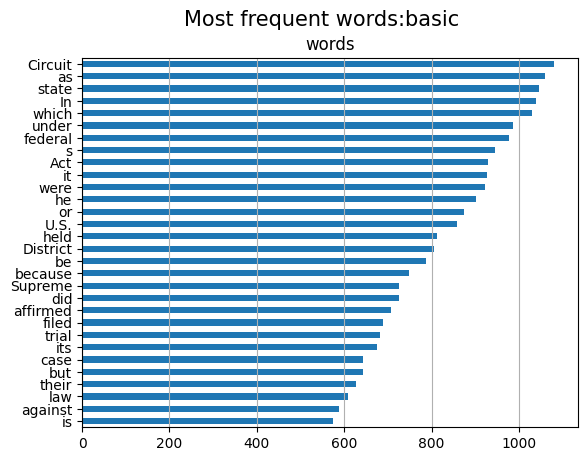

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,the,21420
1,",",13386
2,.,12276
3,of,9925
4,to,7732
...,...,...
17154,Dickinson,1
17155,Democratic-controlled,1
17156,spread,1
17157,discourages,1


In [25]:
word_freq(train_nlp, 'facts', ':basic', True)[0]

##### 기본 불용어 처리

In [26]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴

train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# nltk 기본 불용어를 제거한 결과
train_nlp

,ID,first_party,second_party,facts,first_party_winner
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,ramon nelson riding bike suffered lethal blow ...,0
3,TRAIN_0003,Linkletter,Walker,victor linkletter convicted state court eviden...,0
14,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",named plaintiff james thole others brought cla...,0
16,TRAIN_0016,Plyler,Doe,revision texas education law 1975 allowed stat...,0
21,TRAIN_0021,Bassam Yacoub Salman,United States,maher kara joined citigroups healthcare invest...,0
...,...,...,...,...,...
951,TRAIN_0951,"Ben Ysursa, Idaho Secretary of State, et al.","Pocatello Education Association, et al.",plaintiff case comprised labor organization su...,1
1360,TRAIN_1360,"Michael Sexton, Warden",Nicholas Beaudreaux,nicholas beaudreaux shot killed wayne drummond...,1
1070,TRAIN_1070,Dickinson,Zurko,mary e zurko others applied patent upon method...,1
1035,TRAIN_1035,Georgia,"John Ashcroft, Attorney General",following 2000 census democraticcontrolled geo...,1


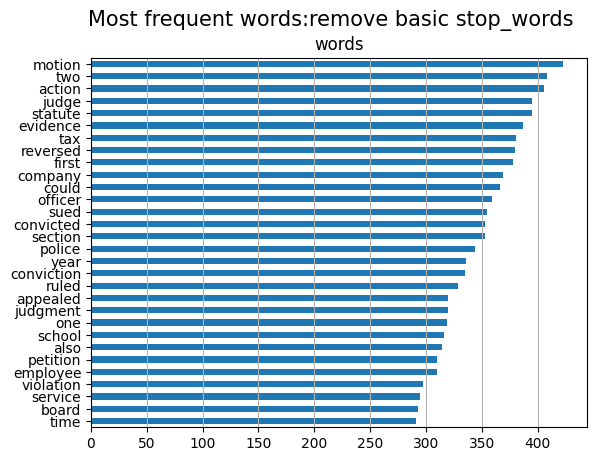

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,5745
1,district,2095
2,state,1826
3,appeal,1793
4,federal,1251
...,...,...
14340,dickinson,1
14341,democraticcontrolled,1
14342,spread,1
14343,discourages,1


In [27]:
word_freq(train_nlp, 'facts', ':remove basic stop_words',True)[0]

In [28]:
train_nlp.head()

,ID,first_party,second_party,facts,first_party_winner
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,ramon nelson riding bike suffered lethal blow ...,0
3,TRAIN_0003,Linkletter,Walker,victor linkletter convicted state court eviden...,0
14,TRAIN_0014,"James J. Thole, et al.","U.S. Bank, N.A., et al.",named plaintiff james thole others brought cla...,0
16,TRAIN_0016,Plyler,Doe,revision texas education law 1975 allowed stat...,0
21,TRAIN_0021,Bassam Yacoub Salman,United States,maher kara joined citigroups healthcare invest...,0


## Define Model & Train

In [38]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

X = get_vector(vectorizer, train_nlp, True)
ylabel = train_nlp["first_party_winner"]

In [39]:
X

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.19606695,
         0.19606695],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [41]:
np.array(X).shape

(1629, 42945)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X, ylabel, test_size=0.3, random_state=42)
X_train

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### LogisticRegression

In [44]:
# lr = LogisticRegression(solver='liblinear', class_weight = 'balanced')
lr = LogisticRegression() # option 지정을 안 하니 성능이 더 좋아짐 -> accuracy : 0.643548, test 적용 시 1: 1124, 0: 116
lr.fit(np.asarray(X_train), y_train)

LogisticRegression()

In [49]:
print("LR Accuracy : %f" % lr.score(np.asarray(X_eval), y_eval)) # 검증 데이터로 성능 측정
# accuracy_score(y_eval, lr.predict(np.asarray(X_eval)))
print("LR F1score : %f" % f1_score(y_eval, lr.predict(np.asarray(X_eval))))
# f1_score(y_eval, lr.predict(np.asarray(X_eval)))

LR Accuracy : 0.531697
LR F1score : 0.533605


In [50]:
test_lr = pd.DataFrame(lr.predict(np.asarray(X_eval)))
test_lr.value_counts()

1    259
0    230
Name: count, dtype: int64

### Test csv 적용

In [51]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [52]:
test["facts"] = test["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# nltk 기본 불용어를 제거한 결과
test

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,1984 bail reform act allowed federal court det...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",lexecon inc defendant class action lawsuit 28 ...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.",2002 2003 fox television station broadcast bil...
3,TEST_0003,Harold Kaufman,United States,trial armed robbery federally insured saving l...
4,TEST_0004,Berger,Hanlon,1993 magistrate judge issued warrant authorizi...
...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",according executive order 12807 signed preside...
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",section 109a clean air act caa requires enviro...
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,linda matteo john madigan created plan utilizi...
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,1972 north carolina board agriculture adopted ...


In [53]:
X_test = get_vector(vectorizer, test, False)
X_test

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Inference & Submission

In [55]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = lr.predict(np.asarray(X_test))
submit

,ID,first_party_winner
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,0
4,TEST_0004,1
...,...,...
1235,TEST_1235,0
1236,TEST_1236,1
1237,TEST_1237,1
1238,TEST_1238,0


In [56]:
submit['first_party_winner'].value_counts()

first_party_winner
1    634
0    606
Name: count, dtype: int64

In [57]:
submit.to_csv('submit.csv', index=False)
print('Done')

Done
